In [ ]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0MB 132kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 93kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
import pandas as pd

In [ ]:
books = pd.read_csv("sample_data/main_dataset.csv")

In [ ]:
books.head()

,image,name,author,format,book_depository_stars,price,currency,old_price,isbn,category,img_paths
0,https://d1w7fb2mkkr3kw.cloudfront.net/assets/i...,This is Going to Hurt,Adam Kay,Paperback,4.5,7.6,$,11.4,9.781510e+12,Medical,dataset/Medical/0000001.jpg
1,https://d1w7fb2mkkr3kw.cloudfront.net/assets/i...,"Thinking, Fast and Slow",Daniel Kahneman,Paperback,4.0,11.5,$,15.0,9.780140e+12,Medical,dataset/Medical/0000002.jpg
2,https://d1w7fb2mkkr3kw.cloudfront.net/assets/i...,When Breath Becomes Air,Paul Kalanithi,Paperback,4.5,9.05,$,11.5,9.781780e+12,Medical,dataset/Medical/0000003.jpg
3,https://d1w7fb2mkkr3kw.cloudfront.net/assets/i...,The Happiness Trap,Russ Harris,Paperback,4.0,8.34,$,13.9,9.781850e+12,Medical,dataset/Medical/0000004.jpg
4,https://d1w7fb2mkkr3kw.cloudfront.net/assets/i...,Man's Search For Meaning,Viktor E. Frankl,Paperback,4.5,9.66,$,NaN,9.781850e+12,Medical,dataset/Medical/0000005.jpg


In [ ]:
c =0 
for i in books.loc[books['category']=='Medical']['img_paths']:
  l = str(i).split("/")
  if l[2] == "0000001.jpg":
    print(c)
    break
  c= c+1

0


In [ ]:
print(c)
b = books.loc[books['category']=="Medical"]
df = b.loc[c]
df

0


image                    https://d1w7fb2mkkr3kw.cloudfront.net/assets/i...
name                                                 This is Going to Hurt
author                                                            Adam Kay
format                                                           Paperback
book_depository_stars                                                  4.5
price                                                                  7.6
currency                                                                 $
old_price                                                             11.4
isbn                                                           9.78151e+12
category                                                           Medical
img_paths                                      dataset/Medical/0000001.jpg
Name: 0, dtype: object

In [ ]:
import os
import cv2
import imutils 
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Hyperparameter


In [ ]:
# Parameter for comparing histograms
correl_threshold = 0.8

# Parameters for SSIM comparison
similarity_index_threshold = 0.0
ssim_matches_limit = 1000

# Parameters for SIFT comparision
sift_features_limit = 1000
lowe_ratio = 0.75
predictions_count = 10

# Parameters to display results
query_image_number = 0
amazon_reviews_count = 3

In [ ]:
def imlist(path):
    return [os.path.join(path, f) for f in os.listdir(path)]

In [ ]:
def imshow(im_title, im):

    plt.figure(figsize=(5,5))
    plt.title(im_title)
    plt.axis("off")
    if len(im.shape) == 2:
        plt.imshow(im, cmap = "gray")
    else:
        im_display = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        plt.imshow(im_display)
    plt.show()

In [ ]:
l = os.listdir('drive/MyDrive/New folder')

In [ ]:
train_paths = []
for i in l:
  train_path = 'drive/MyDrive/New folder/'+i
  for root, dirs, files in os.walk(train_path):
      for file in files:
          train_paths.append((os.path.join(root, file)))
len(train_paths)

32614

In [ ]:
query_path = "sample_data/test"
query_paths = imlist(query_path)
len(query_paths)

0

In [ ]:
%%time

hist_train = []

for path in train_paths:
    image = cv2.imread(path)
   
    if image is None:
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # extract a 3D RGB color histogram from the image,
    # using 8 bins per channel, normalize, and update
    # the index
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, None)
    hist_train.append((path,hist))
    
len(hist_train)

CPU times: user 56.4 s, sys: 13.3 s, total: 1min 9s
Wall time: 1h 46min 1s


In [ ]:
# Saving the train data histograms to a pickle file

with open('train_hist_data.pkl', 'wb') as f:
    pickle.dump(hist_train, f)

In [ ]:
with open('sample_data/train_hist_data.pkl', 'rb') as f:
    hist_train = pickle.load(f)

len(hist_train)

32581

In [ ]:
%%time

hist_query = []
for path in query_paths:
    image = cv2.imread(path)
    
    if image is None:
        continue
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # extract a 3D RGB color histogram from the image,
    # using 8 bins per channel, normalize, and update the index
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, None)
    hist_query.append((path,hist))

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.39 µs


In [ ]:
%%time

hist_matches = []
for i in range(len(hist_query)):
    matches = []
    for j in range(len(hist_train)):
        cmp = cv2.compareHist(hist_query[i][1], hist_train[j][1], cv2.HISTCMP_CORREL)
        if cmp > correl_threshold:
            matches.append((cmp,hist_train[j][0]))
    matches.sort(key=lambda x : x[0] , reverse = True)
    hist_matches.append((hist_query[i][0],matches))

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11.9 µs


In [ ]:
hit_count_hist = 0
miss_count_hist = 0

for i in range(len(hist_matches)):
    q_text = hist_matches[i][0].split("/")[-1]
    p_text = []
    for j in range(len(hist_matches[i][1])):
        text = hist_matches[i][1][j][1].split("/")[-1]
        p_text.append(text)
    if q_text in p_text:
        hit_count_hist += 1
    else:
        miss_count_hist += 1

print("query set is ", query_path.split("/")[-1])        
print("\n")
print("Total number of images = ",len(hist_matches))
print("Number of correctly retrieved images = ",hit_count_hist)
print("Number of images that could not be retrieved = ",miss_count_hist)

query set is  test


Total number of images =  0
Number of correctly retrieved images =  0
Number of images that could not be retrieved =  0


In [ ]:

from skimage.measure import compare_ssim as ssim

In [ ]:
def similarity_index(q_path,m_path):
    q_i = cv2.imread(q_path,0)
    q_i = cv2.resize(q_i,(8,8))
    m_i = cv2.imread(m_path,0)
    m_i = cv2.resize(m_i,(8,8))
    return ssim(q_i,m_i)

In [ ]:
hist_matches

[]

In [ ]:
%%time

ssim_matches = []

for i in range(len(hist_matches)):
    query_image_path = hist_matches[i][0]
    matches = []
    for j in range(len(hist_matches[i][1])):
        match_image_path = hist_matches[i][1][j][1]
        si = similarity_index(query_image_path,match_image_path)
        if si > similarity_index_threshold:
            matches.append((si,match_image_path))
    matches.sort(key=lambda x : x[0] , reverse = True)
    ssim_matches.append((query_image_path,matches[:ssim_matches_limit]))

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.54 µs


In [ ]:
hit_count_ssim = 0
miss_count_ssim = 0

for i in range(len(ssim_matches)):
    q_text = ssim_matches[i][0].split("/")[-1]
    p_text = []
    for j in range(len(ssim_matches[i][1])):
        text = ssim_matches[i][1][j][1].split("/")[-1]
        p_text.append(text)
    if q_text in p_text:
        hit_count_ssim += 1
    else:
        miss_count_ssim += 1

print("query set is ", query_path.split("/")[-1])        
print("\n")
print("Total number of images = ",len(ssim_matches))
print("Number of correctly retrieved images = ",hit_count_ssim)
print("Number of images that could not be retrieved = ",miss_count_ssim)

query set is  test


Total number of images =  0
Number of correctly retrieved images =  0
Number of images that could not be retrieved =  0


In [ ]:
def gen_sift_features(image):
    sift = cv2.xfeatures2d.SIFT_create(sift_features_limit)
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(image, None)
    return kp, desc

In [ ]:
# FLANN matcher
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

In [ ]:


predictions = []
for i in range(len(ssim_matches)):
    matches_flann = []
    # Reading query image
    q_path = ssim_matches[i][0]
    q_img = cv2.imread(q_path)
    if q_img is None:
        continue
    q_img = cv2.cvtColor(q_img, cv2.COLOR_BGR2RGB)
    # Generating SIFT features for query image
    q_kp,q_des = gen_sift_features(q_img)
    if q_des is None:
        continue
    
    for j in range(len(ssim_matches[i][1])):
        matches_count = 0
        m_path = ssim_matches[i][1][j][1]
        m_img = cv2.imread(m_path)        
        if m_img is None:
            continue
        m_img = cv2.cvtColor(m_img, cv2.COLOR_BGR2RGB)
        # Generating SIFT features for predicted ssim images
        m_kp,m_des = gen_sift_features(m_img)
        if m_des is None:
            continue
        # Calculating number of feature matches using FLANN
        matches = flann.knnMatch(q_des,m_des,k=2)
        #ratio query as per Lowe's paper
        matches_count = 0
        for x,(m,n) in enumerate(matches):
            if m.distance < lowe_ratio*n.distance:
                matches_count += 1
        matches_flann.append((matches_count,m_path))
    matches_flann.sort(key=lambda x : x[0] , reverse = True)
    predictions.append((q_path,matches_flann[:predictions_count]))

In [ ]:
hit_count = 0
miss_count = 0

hit_top_1 = 0
hit_top_2 = 0
hit_top_3 = 0
hit_top_4 = 0

for i in range(len(predictions)):
    q_text = predictions[i][0].split("/")[-1]
    p_text = []
    if len(predictions[i][1]) == 0:
        miss_count += 1
        continue
    for j in range(len(predictions[i][1])):
        text = predictions[i][1][j][1].split("/")[-1]
        p_text.append(text)
    try:
        if q_text == p_text[0]:
            hit_top_1 += 1
        elif q_text == p_text[1]:
            hit_top_2 += 1 
        elif q_text == p_text[2]:
            hit_top_3 += 1 
        elif q_text == p_text[3]:
            hit_top_4 += 1 
        else:
            miss_count += 1
    except IndexError:
        miss_count += 1

predic_len = 20

hit_top_2 += hit_top_1
hit_top_3 += hit_top_2
hit_top_4 += hit_top_3
hit_count = hit_top_4


print("query set is ", query_path.split("/")[-1])        
print("\n")
print("Number of correctly retrieved images = ",hit_count)
print("Number of images that could not be retrieved = ",miss_count)
print("\n")
print(f"Accuracy @ Top 1 predictions = {hit_top_1*100/predic_len}%")
print(f"Accuracy @ Top 2 predictions = {hit_top_2*100/predic_len}%")
print(f"Accuracy @ Top 3 predictions = {hit_top_3*100/predic_len}%")
print(f"Accuracy @ Top 4 predictions = {hit_top_4*100/predic_len}%")


query set is  test


Number of correctly retrieved images =  0
Number of images that could not be retrieved =  0


Accuracy @ Top 1 predictions = 0.0%
Accuracy @ Top 2 predictions = 0.0%
Accuracy @ Top 3 predictions = 0.0%
Accuracy @ Top 4 predictions = 0.0%


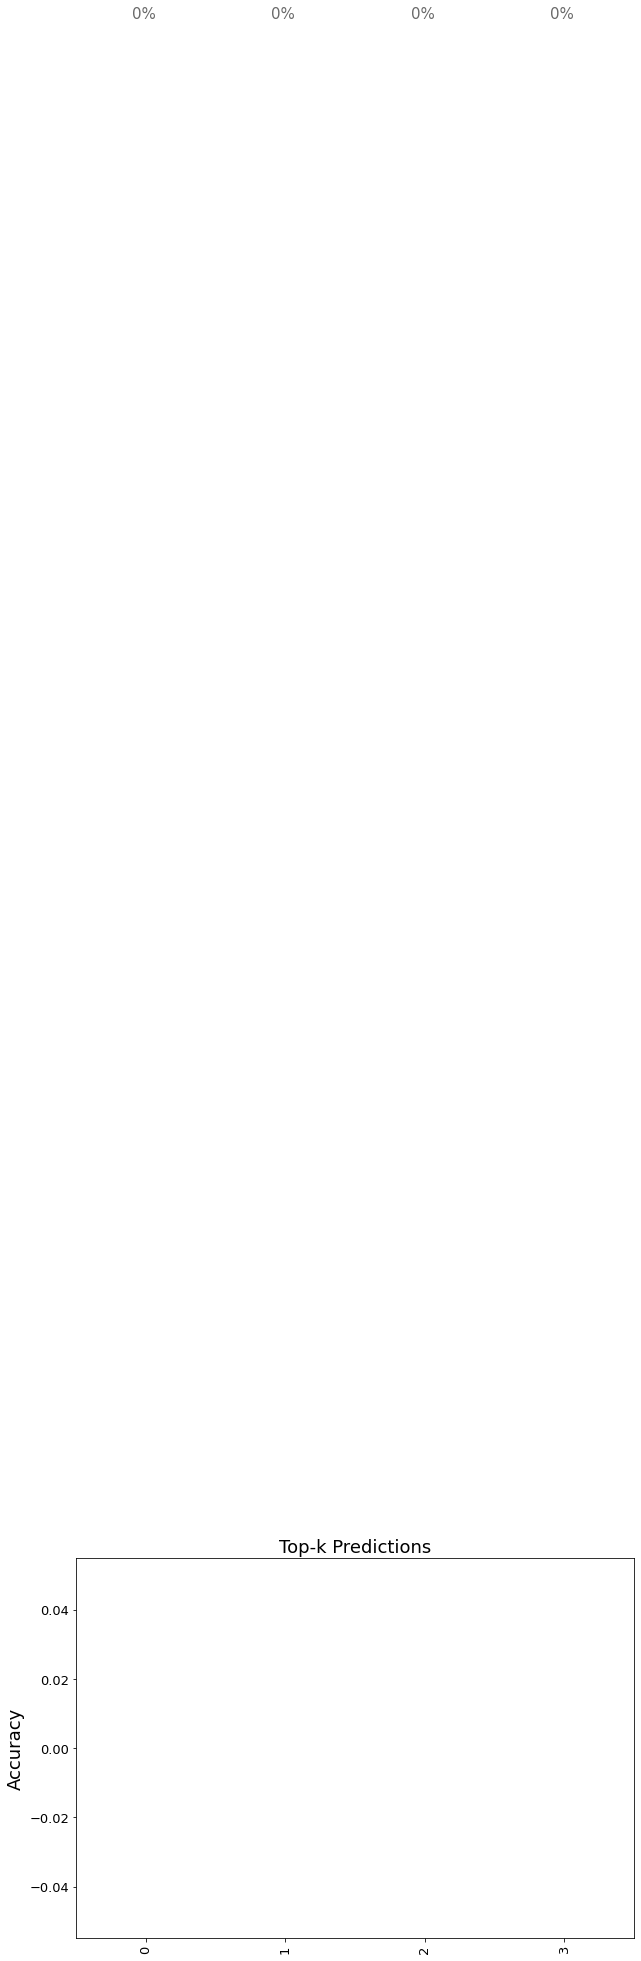

In [ ]:
frequencies = [hit_top_1,hit_top_2,hit_top_3,hit_top_4]
freq_series = pd.Series(frequencies)
ax = freq_series.plot(kind='bar', figsize=(10,7),
                                        color="brown", fontsize=13);
ax.set_alpha(0.8)
ax.set_title('Top-k Predictions',fontsize=18)
ax.set_ylabel('Accuracy',fontsize=18)


# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.15, i.get_height()+.5, \
            str(round((i.get_height()), 2))+'%', fontsize=15,
                color='dimgrey')

In [ ]:
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

ValueError: ignored

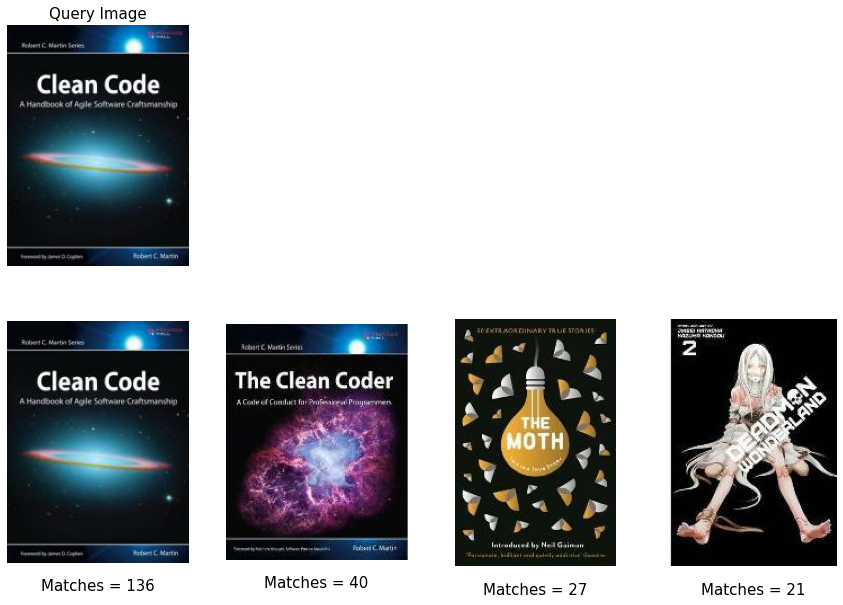

In [ ]:
title_text = ""
plt.figure(figsize=(15,10))

# Loading query image
query_image = cv2.imread(predictions[query_image_number][0])
query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
plt.subplot(2, 4, 1)
plt.axis('off')
plt.title("Query Image",fontsize=15)
plt.imshow(query_image)

top_prediction_image = cv2.imread(predictions[query_image_number][1][0][1])
top_prediction_image = cv2.cvtColor(top_prediction_image, cv2.COLOR_BGR2RGB)

# Loading predicted images
for i in range(predictions_count):
    title_text = ""
    img = cv2.imread(predictions[query_image_number][1][i][1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    title_text = "Matches = " + str(predictions[query_image_number][1][i][0])
    plt.subplot(2,4,5+i)
    plt.axis('off')
    plt.text(0.5,-0.1,title_text,ha='center',va='center',fontsize=15,transform=plt.subplot(2,4,5+i).transAxes)
    plt.imshow(img)

plt.show()

In [ ]:
predictions

[]

In [ ]:

import random

q_kp,q_des = gen_sift_features(query_image)
m_kp,m_des = gen_sift_features(top_prediction_image)
matches_old = flann.knnMatch(q_des,m_des,k=2)
matches = random.sample(matches_old, 50)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < lowe_ratio*n.distance:
        matchesMask[i]=[1,0]
        
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

kp_img = cv2.drawMatchesKnn(query_image,q_kp,top_prediction_image,m_kp,matches,None,**draw_params)

plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(kp_img)
plt.show()

NameError: ignored

In [ ]:
!pip install flask-ngrok

In [ ]:
!pip install flask-cors

In [ ]:
from flask import Flask,request,jsonify
from flask_cors import CORS
from werkzeug.utils import secure_filename
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
CORS(app)
run_with_ngrok(app)
app.config['UPLOAD_FOLDER'] = 'sample_data/test'
  
@app.route("/image",methods=['POST'])
def home():
  file = request.files['image']
  filename = secure_filename(file.filename)
  file.save(os.path.join(app.config['UPLOAD_FOLDER'], filename))
  return jsonify({'message':'success'})

@app.route("/getImage",methods=['GET'])
def display():
  pred = predict()
  p = pred[1]
  lr = []
  for i in p:
    a = i[1].split("/")
    category = a[3]
    filename = a[4]
    books = pd.read_csv("sample_data/main_dataset.csv")
    c =0 
    for j in books.loc[books['category']==a[3]]['img_paths']:
      l = str(j).split("/")
      if l[2] == str(a[4]):
        print(c)
        break
      c = c+1
    b = books.loc[books['category']==a[3]]
    df = b.iloc[c]
    print(df)
    d = {'category':category,'filename':filename,'name':df['name'],'author':df['author'],'isbn':int(df['isbn']),'image_url':df['image']}
    print(d)
    lr.append(d)
  return jsonify(lr)


app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://475d74f9eaa9.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [19/May/2021 09:12:59] "POST /image HTTP/1.1" 200 -


2
query set is  test


Total number of images =  1
Number of correctly retrieved images =  1
Number of images that could not be retrieved =  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


query set is  test


Total number of images =  1
Number of correctly retrieved images =  1
Number of images that could not be retrieved =  0
2
image                    https://d1w7fb2mkkr3kw.cloudfront.net/assets/i...
name                                        Don't Make Me Think, Revisited
author                                                          Steve Krug
format                                                           Paperback
book_depository_stars                                                    4
price                                                                23.03
currency                                                                 $
old_price                                                             42.9
isbn                                                           9.78032e+12
category                                                         Computing
img_paths                                    dataset/Computing/0000003.jpg
Name: 5925, dtype: object
{'cate

127.0.0.1 - - [19/May/2021 09:13:09] "GET /getImage HTTP/1.1" 200 -


222
image                    https://d1w7fb2mkkr3kw.cloudfront.net/assets/i...
name                                       Harvey Penick's Little Red Book
author                                                       Harvey Penick
format                                                            Hardback
book_depository_stars                                                  4.5
price                                                                17.77
currency                                                                 $
old_price                                                             21.6
isbn                                                           9.78145e+12
category                                                             Sport
img_paths                                        dataset/Sport/0000223.jpg
Name: 25893, dtype: object
{'category': 'Sport', 'filename': '0000223.jpg', 'name': "Harvey Penick's Little Red Book", 'author': 'Harvey Penick', 'isbn': 9781450000000, 'i

In [ ]:
!pip install werkzeug

In [ ]:
def predict():
  query_path = "sample_data/test"
  query_paths = imlist(query_path)
  print(len(query_paths))
  
  hist_query = []
  for path in query_paths:
    image = cv2.imread(path)
    
    if image is None:
        continue
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # extract a 3D RGB color histogram from the image,
    # using 8 bins per channel, normalize, and update the index
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, None)
    hist_query.append((path,hist))

  hist_matches = []
  for i in range(len(hist_query)):
    matches = []
    for j in range(len(hist_train)):
        cmp = cv2.compareHist(hist_query[i][1], hist_train[j][1], cv2.HISTCMP_CORREL)
        if cmp > correl_threshold:
            matches.append((cmp,hist_train[j][0]))
    matches.sort(key=lambda x : x[0] , reverse = True)
    hist_matches.append((hist_query[i][0],matches)) 


  hit_count_hist = 0
  miss_count_hist = 0
  for i in range(len(hist_matches)):
    q_text = hist_matches[i][0].split("/")[-1]
    p_text = []
    for j in range(len(hist_matches[i][1])):
      text = hist_matches[i][1][j][1].split("/")[-1]
      p_text.append(text)
    if q_text in p_text:
        hit_count_hist += 1
    else:
        miss_count_hist += 1

  print("query set is ", query_path.split("/")[-1])        
  print("\n")
  print("Total number of images = ",len(hist_matches))
  print("Number of correctly retrieved images = ",hit_count_hist)
  print("Number of images that could not be retrieved = ",miss_count_hist)

  ssim_matches = []

  for i in range(len(hist_matches)):
    query_image_path = hist_matches[i][0]
    matches = []
    for j in range(len(hist_matches[i][1])):
        match_image_path = hist_matches[i][1][j][1]
        si = similarity_index(query_image_path,match_image_path)
        if si > similarity_index_threshold:
            matches.append((si,match_image_path))
    matches.sort(key=lambda x : x[0] , reverse = True)
    ssim_matches.append((query_image_path,matches[:ssim_matches_limit]))

  hit_count_ssim = 0
  miss_count_ssim = 0

  for i in range(len(ssim_matches)):
    q_text = ssim_matches[i][0].split("/")[-1]
    p_text = []
    for j in range(len(ssim_matches[i][1])):
        text = ssim_matches[i][1][j][1].split("/")[-1]
        p_text.append(text)
    if q_text in p_text:
        hit_count_ssim += 1
    else:
        miss_count_ssim += 1

  print("query set is ", query_path.split("/")[-1])        
  print("\n")
  print("Total number of images = ",len(ssim_matches))
  print("Number of correctly retrieved images = ",hit_count_ssim)
  print("Number of images that could not be retrieved = ",miss_count_ssim)


  FLANN_INDEX_KDTREE = 0
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
  search_params = dict(checks=50)   # or pass empty dictionary
  flann = cv2.FlannBasedMatcher(index_params,search_params)


  predictions = []
  for i in range(len(ssim_matches)):
    matches_flann = []
    # Reading query image
    q_path = ssim_matches[i][0]
    q_img = cv2.imread(q_path)
    if q_img is None:
        continue
    q_img = cv2.cvtColor(q_img, cv2.COLOR_BGR2RGB)
    # Generating SIFT features for query image
    q_kp,q_des = gen_sift_features(q_img)
    if q_des is None:
        continue
    
    for j in range(len(ssim_matches[i][1])):
        matches_count = 0
        m_path = ssim_matches[i][1][j][1]
        m_img = cv2.imread(m_path)        
        if m_img is None:
            continue
        m_img = cv2.cvtColor(m_img, cv2.COLOR_BGR2RGB)
        # Generating SIFT features for predicted ssim images
        m_kp,m_des = gen_sift_features(m_img)
        if m_des is None:
            continue
        # Calculating number of feature matches using FLANN
        matches = flann.knnMatch(q_des,m_des,k=2)
        #ratio query as per Lowe's paper
        matches_count = 0
        for x,(m,n) in enumerate(matches):
            if m.distance < lowe_ratio*n.distance:
                matches_count += 1
        matches_flann.append((matches_count,m_path))
    matches_flann.sort(key=lambda x : x[0] , reverse = True)
    predictions.append((q_path,matches_flann[:predictions_count]))
  return predictions[len(predictions)-1] 

In [ ]:
pred = predict()

2
query set is  test


Total number of images =  1
Number of correctly retrieved images =  1
Number of images that could not be retrieved =  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


query set is query set is  test


Total number of images =  1
Number of correctly retrieved images =  1
Number of images that could not be retrieved =  0
 query set is test


Total number of images =  1
Number of correctly retrieved images =  1
Number of images that could not be retrieved =  0
 test


Total number of images =  2
Number of correctly retrieved images =  2
Number of images that could not be retrieved =  0
2
image                    https://d1w7fb2mkkr3kw.cloudfront.net/assets/i...
name                                               Thinking, Fast and Slow
author                                                     Daniel Kahneman
format                                                           Paperback
book_depository_stars                                                    4
price                                                                 11.5
currency                                                                 $
old_price                                         

In [ ]:
pred

('sample_data/test/0000001.jpg',
 [(238, 'drive/MyDrive/New folder/Humour/0000001.jpg'),
  (238, 'drive/MyDrive/New folder/Medical/0000001.jpg'),
  (238, 'drive/MyDrive/New folder/Biography/0000001.jpg'),
  (177, 'drive/MyDrive/New folder/Humour/0000519.jpg')])